In [1]:
from __future__ import print_function, division
import numpy as np
import pickle as pkl
import glob 
import sncosmo
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
!ls meanspec*

meanspecIIb.p  meanspecIb.p   meanspecIc.p   meanspecIcbl.p


In [3]:
subtypes = {"Ib": None, "Ic": None, "Icbl": None, "IIb": None}

for st in subtypes:
    subtypes[st] = pkl.load(open("meanspec" + st + ".p", "rb"))
#subtypes


In [4]:
norms = {-10:1, -5:1.3, 0:1.6, 5:1.3, 10:1.15, 15:1, 20:0.85, 25:0.75, 30:0.7}
subtypesArray = {}
subtypesArrayErr = {}
subtypesPhases = {}
subtypesW = {}
for st in subtypes:   
    subtypesPhases[st] = np.sort(np.array(subtypes[st].keys()).astype(int)) + 10
    #print (subtypesPhases[st])
    subtypesW[st] = np.array(subtypes[st]['0'][0])
    #print (st, subtypesPhases[st], len(subtypesPhases[st]))
    subtypesArray[st] = np.empty((len(subtypesPhases[st]), len(subtypesW[st])))
    subtypesArrayErr[st] = np.empty((len(subtypesPhases[st]), len(subtypesW[st])))
    #print (subtypesPhases[st][2])
    #norm = sum(subtypesPhases[st][2]#[(subtypesW[st]<8000) * (subtypesW[st]>3500)])
    for i, phase in enumerate(subtypesPhases[st]):
        phs = "%d"%(phase-10)
        #print(phase)
        if phs == '5': phs = '05'
        subtypesArray[st][i] =  subtypes[st][phs][1] 
        subtypesArray[st][i] = subtypesArray[st][i] / sum(subtypesArray[st][i][(subtypesW[st]<6000) * 
                                                     (subtypesW[st]>3500)]) * norms[phase-10]*1e3
        subtypesArrayErr[st][i] =  subtypes[st][phs][2]
                                 

In [5]:
model = {}

In [6]:
def plotSubtype(st):
    fig = pl.figure(figsize = (15,5))
    fig.add_subplot(131)
    pl.imshow(subtypesArray[st], aspect=100)
    pl.title(st)
    fig.add_subplot(132)
    for i, flx in enumerate(subtypesArray[st]):
        pl.errorbar(subtypesW[st], flx + i, yerr = subtypesArrayErr[st][i])
        pl.text(9500, i, "phase %d"%subtypesPhases[st][i])
        pl.xlabel("wavelength")
        pl.ylabel("relative flux")
    fig.add_subplot(133)
    for i, flx in enumerate(subtypesArray[st]):
        pl.errorbar(subtypesW[st], flx, yerr = subtypesArrayErr[st][i])
        pl.text(9500, i, "phase %d"%subtypesPhases[st][i])
        pl.xlabel("wavelength")
        pl.ylabel("relative flux")
    source = sncosmo.TimeSeriesSource(subtypesPhases[st], subtypesW[st], subtypesArray[st])
    model[st] = sncosmo.Model(source)

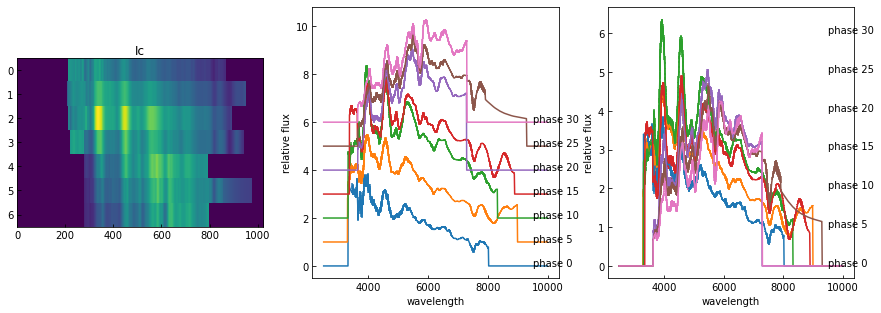

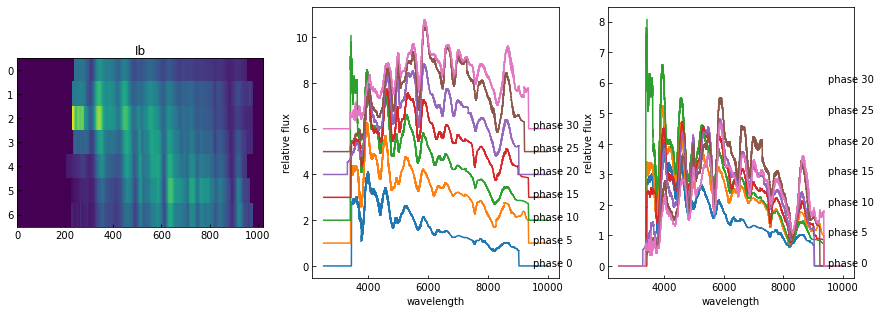

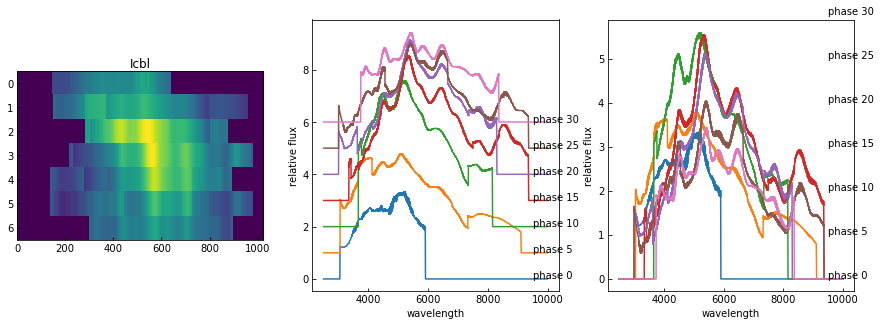

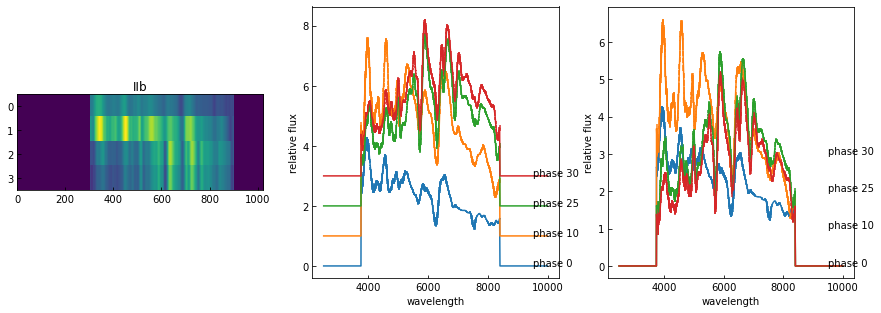

In [7]:
for st in subtypes:
    plotSubtype(st)
    

In [8]:
model

{'IIb': <sncosmo.models.Model at 0x10d98fe90>,
 'Ib': <sncosmo.models.Model at 0x10bac4c90>,
 'Ic': <sncosmo.models.Model at 0x109999110>,
 'Icbl': <sncosmo.models.Model at 0x10d00b850>}

In [9]:
import sncosmo
from astropy.table import Table
obs = Table({'time': np.linspace(56196.19,56230.19,100),
             'band': ['desg']*100,
             'gain': [1.]*100,
             'skynoise': [191.27]*100,
             'zp': [30.]*100,
             'zpsys':['ab']*100})
#print (obs)

In [10]:
params = {'z': 0.4, 't0': 56200.0}#, 'x0':1.e-5, 'x1': 0.1, 'c': -0.1}

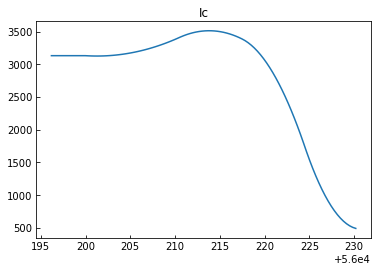

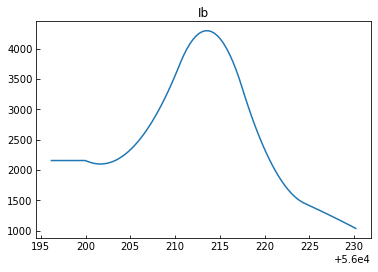

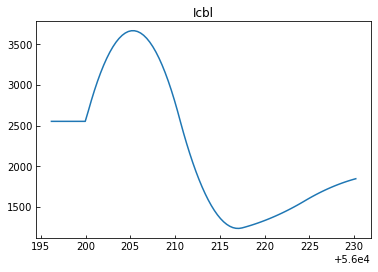

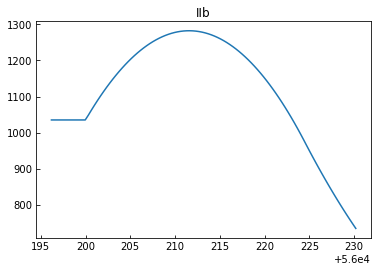

In [11]:
for st in subtypes:
    lcs = sncosmo.realize_lcs(obs, model[st], [params])
    #print (lcs)
    pl.figure()
    pl.title(st)
    pl.errorbar(lcs[0]['time'].quantity, lcs[0]['flux'].quantity*1e-17, yerr = lcs[0]['fluxerr'].quantity*1e-17)
    